<a href="https://colab.research.google.com/github/laraAkg/Data-Science-Project/blob/main/Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyextremes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 5.1 MB/s eta 0:00:00


In [ ]:
# === 0) Colab/Drive Setup & Project Paths ===

import os, json, math, time, random, csv
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)

from pathlib import Path

try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive', force_remount=True)

DEFAULT_PROJECT_DIR = "MyDrive/Generated Data for Data science project"
BASE_DIR = Path("/content/drive") / DEFAULT_PROJECT_DIR if IN_COLAB else Path("./project_outputs")

DATA_DIR    = BASE_DIR / "datasets"
PLOTS_DIR   = BASE_DIR / "plots"
META_DIR    = BASE_DIR / "metadata"
MODELS_DIR  = BASE_DIR / "models_tf"
REPORTS_DIR = BASE_DIR / "reports"
REAL_DIR    = BASE_DIR / "real"
BEST_MODEL_PATH = MODELS_DIR / "best_model_keras.h5"
BEST_MODEL_META = REPORTS_DIR / "best_model_meta.json"
CSV_UPLOAD_DIR = BASE_DIR / "csv_upload"
EVAL_DIR       = REPORTS_DIR / "best_model_eval"

assert BEST_MODEL_META.exists(), f"Best model meta file fehlt: {BEST_MODEL_META}"
with open(BEST_MODEL_META, "r", encoding="utf-8") as f:
    best_meta = json.load(f)

for p in [DATA_DIR, PLOTS_DIR, META_DIR, MODELS_DIR, REPORTS_DIR, REAL_DIR, CSV_UPLOAD_DIR, EVAL_DIR]:
    p.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (128, 128)  # (H, W)

print("BASE_DIR:", BASE_DIR)
print("CSV_UPLOAD_DIR:", CSV_UPLOAD_DIR)
print("EVAL_DIR:", EVAL_DIR)

# Best model calibration & thresholds from meta (final retrained model)
t_opt_best  = float(best_meta["t_opt"])
T_best      = float(best_meta.get("T", 1.0))
t_low_best  = float(best_meta.get("t_low", 0.30))
t_high_best = float(best_meta.get("t_high", 0.70))

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

DEVICE = "GPU" if len(tf.config.list_physical_devices('GPU')) > 0 else "CPU"
BATCH_SIZE_DEFAULT = 32

# Debug mode consistent with training notebook (controls CV splits)
DEBUG_MODE = True  # set to False when you run the full CV

print("TF device:", DEVICE)


Mounted at /content/drive
BASE_DIR: /content/drive/MyDrive/Generated Data for Data science project
CSV_UPLOAD_DIR: /content/drive/MyDrive/Generated Data for Data science project/csv_upload
EVAL_DIR: /content/drive/MyDrive/Generated Data for Data science project/reports/best_model_eval
TF device: GPU


In [ ]:
# === 2.1) Load metadata & build samples table (incl. augs) ===
INDEX_JSON = META_DIR / "datasets_index.json"
with open(INDEX_JSON, "r", encoding="utf-8") as f:
    records = json.load(f)

samples = []
uniq_rows = []
for r in records:
    ds_id = r["dataset_id"]
    label = int(r["heavy_tailed"])
    uniq_rows.append({"dataset_id": ds_id, "label": label})
    samples.append({
        "dataset_id": ds_id,
        "variant": "original",
        "paths": r["plots"]["original"],
        "label": label,
    })
    for aug_name, aug_paths in r["plots"]["aug"].items():
        samples.append({
            "dataset_id": ds_id,
            "variant": aug_name,
            "paths": aug_paths,
            "label": label,
        })

print("Unique dataset_ids:", len(uniq_rows))
print("Total samples (incl. augs):", len(samples))

# === 2.2) Image helpers & tf.data builder (wie im Training) ===
def load_gray_resized(path: str | Path) -> np.ndarray:
    img = Image.open(path).convert("L")
    img = img.resize((IMG_SIZE[1], IMG_SIZE[0]))
    arr = np.asarray(img).astype("float32") / 255.0
    return arr

def stack_zipf_qq_me(paths_dict: dict) -> np.ndarray:
    z = load_gray_resized(paths_dict["zipf"])
    q = load_gray_resized(paths_dict["qq_exp"])
    m = load_gray_resized(paths_dict["me"])
    return np.stack([z, q, m], axis=-1)

def sample_to_example(row: dict) -> tuple[np.ndarray, np.float32]:
    x = stack_zipf_qq_me(row["paths"])
    y = np.float32(row["label"])
    return x, y

def rows_for_ids(id_array) -> list[dict]:
    s = set(id_array)
    return [row for row in samples if row["dataset_id"] in s]

def make_tf_dataset(rows: list[dict],
                    batch_size: int = BATCH_SIZE_DEFAULT,
                    shuffle: bool = False) -> tf.data.Dataset:
    xs, ys = [], []
    for r in rows:
        x, y = sample_to_example(r)
        xs.append(x)
        ys.append(y)
    xs = np.stack(xs, axis=0)
    ys = np.array(ys, dtype=np.float32)
    ds = tf.data.Dataset.from_tensor_slices((xs, ys))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(xs), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


Unique dataset_ids: 600
Total samples (incl. augs): 2400


In [ ]:
# === 3.1) CV-Results-Loader & Best-Row-Funktion (aus Training übernommen) ===
def load_cv_results(csv_path: str | Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df = df.dropna(how="all")
    for col in [
        "acc","f1","roc_auc","pr_auc","ece","abstain","acc_decided","threshold",
        "ds_acc","ds_f1","ds_roc_auc","ds_pr_auc",
        "T","t_low","t_high","target_precision"
    ]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def best_row(df_val: pd.DataFrame,
             primary: str = "roc_auc",
             secondary: str = "f1",
             higher_is_better: dict | None = None) -> pd.Series:
    p, s = primary.lower(), secondary.lower()
    hib = {"roc_auc": True, "f1": True, "acc": True, "pr_auc": True, "ece": False}
    if higher_is_better:
        hib.update({k.lower(): v for k, v in higher_is_better.items()})
    if df_val.empty:
        raise ValueError("No validation rows found in CSV (split=='val').")

    def sort_key(row):
        pk = row.get(p, np.nan)
        sk = row.get(s, np.nan)
        pk = pk if hib.get(p, True) else -pk
        sk = sk if hib.get(s, True) else -sk
        return (np.nan_to_num(pk, nan=-np.inf), np.nan_to_num(sk, nan=-np.inf))

    best_idx = max(df_val.index, key=lambda i: sort_key(df_val.loc[i]))
    return df_val.loc[best_idx]


def summarize_hparams(df_val: pd.DataFrame,
                      primary: str = "roc_auc",
                      secondary: str = "f1") -> pd.DataFrame:
    """
    Aggregate validation metrics across folds for each hyperparameter configuration.
    Must match training notebook logic.
    """
    cfg_cols = ["model","lr","l2","epochs","bs","dropout"]
    g = df_val.groupby(cfg_cols)

    rows = []
    for cfg, sub in g:
        row = dict(zip(cfg_cols, cfg))
        row["n_folds"] = sub["fold"].nunique()
        for col in [primary, secondary]:
            row[f"mean_{col}"] = sub[col].mean()
            row[f"std_{col}"]  = sub[col].std(ddof=0)
        rows.append(row)

    return pd.DataFrame(rows)


def select_best_config(hp_df: pd.DataFrame,
                       primary: str = "roc_auc",
                       secondary: str = "f1") -> pd.Series:
    """
    Select the hyperparameter configuration with best mean primary metric,
    breaking ties by mean secondary metric.
    Must match training notebook logic.
    """
    p = f"mean_{primary}"
    s = f"mean_{secondary}"

    if hp_df.empty:
        raise ValueError("Hyperparameter summary is empty.")

    best_idx = max(
        hp_df.index,
        key=lambda i: (hp_df.loc[i, p], hp_df.loc[i, s])
    )
    return hp_df.loc[best_idx]

# === 3.2) Bestes Modell auswählen ===
CV_CSV = REPORTS_DIR / "cv_results_tuned_dropout_keras.csv"
assert CV_CSV.exists(), f"CV-Results CSV nicht gefunden: {CV_CSV}"

df_cv = load_cv_results(CV_CSV)
df_val = df_cv[df_cv["split"] == "val"].copy()
assert not df_val.empty, "Keine Zeilen mit split=='val' in CV-CSV gefunden."

# Hyperparameter-Aggregation über Folds (wie im Trainings-Notebook)
hp_summary = summarize_hparams(df_val, primary="roc_auc", secondary="f1")
assert not hp_summary.empty, "Keine Hyperparameter-Konfigurationen in den Validation-Ergebnissen gefunden."

best_cfg = select_best_config(hp_summary, primary="roc_auc", secondary="f1")
if hasattr(best_cfg, "to_dict"):
    best_cfg_dict = best_cfg.to_dict()
else:
    best_cfg_dict = dict(best_cfg)

# Innerhalb dieser besten Konfiguration: besten Fold wählen (für CV-Split-Rekonstruktion)
mask_cfg = (
    (df_val["model"]   == best_cfg_dict["model"]) &
    (df_val["lr"]      == best_cfg_dict["lr"]) &
    (df_val["l2"]      == best_cfg_dict["l2"]) &
    (df_val["epochs"]  == best_cfg_dict["epochs"]) &
    (df_val["bs"]      == best_cfg_dict["bs"]) &
    (df_val["dropout"] == best_cfg_dict["dropout"])
)
df_val_cfg = df_val[mask_cfg].copy()
assert not df_val_cfg.empty, "Keine Zeilen für die beste Hyperparameter-Konfiguration gefunden."

best = best_row(df_val_cfg, primary="roc_auc", secondary="f1")

best_fold       = int(best["fold"])
best_model_path = Path(best_meta["model_path"])  # final retrained model path
target_precision_best = float(best_meta.get("target_precision", np.nan))

print("=== Bestes Modell (Val-basiert, aggregierte Hyperparameter-Konfiguration) ===")
print(f"Fold (für CV-Split-Rekonstruktion): {best_fold}")
print(f"Modell: {best.get('model', 'unknown')}")
print(f"Pfad (final retrained model): {best_model_path}")
print(f"LR: {best.get('lr')}, L2: {best.get('l2')}, Epochen: {best.get('epochs')}, "
      f"Batch Size: {best.get('bs', 'NA')}, Dropout: {best.get('dropout', 'NA')}")
print(f"Val ROC-AUC (dieser Fold): {best.get('roc_auc'):.4f}, PR-AUC: {best.get('pr_auc'):.4f}, "
      f"Acc: {best.get('acc'):.4f}, F1: {best.get('f1'):.4f}")
print(f"T (Temperatur, final model): {T_best:.3f}")
print(f"t_low: {t_low_best:.3f}, t_high: {t_high_best:.3f}, target_precision: {target_precision_best}")
print(f"CV mean ROC-AUC (best config): {best_meta.get('cv_mean_roc_auc', float('nan')):.4f} "
      f"+/- {best_meta.get('cv_std_roc_auc', float('nan')):.4f}")
print(f"CV mean F1 (best config):      {best_meta.get('cv_mean_f1', float('nan')):.4f} "
      f"+/- {best_meta.get('cv_std_f1', float('nan')):.4f}")


=== Bestes Modell (Val-basiert, aggregierte Hyperparameter-Konfiguration) ===
Fold (für CV-Split-Rekonstruktion): 1
Modell: baseline
Pfad (final retrained model): /content/drive/MyDrive/Generated Data for Data science project/models_tf/best_model_keras.h5
LR: 0.001, L2: 0.0, Epochen: 2, Batch Size: 16, Dropout: 0.0
Val ROC-AUC (dieser Fold): 0.7623, PR-AUC: 0.7606, Acc: 0.6800, F1: 0.6981
T (Temperatur, final model): 1.000
t_low: 0.300, t_high: 0.700, target_precision: 0.9
CV mean ROC-AUC (best config): 0.7623 +/- 0.0000
CV mean F1 (best config):      0.6981 +/- 0.0000


In [ ]:
# === 4.1) Fold-Splits wie im Training rekonstruieren ===
uniq_ids   = np.array([r["dataset_id"] for r in uniq_rows])
uniq_label = np.array([r["label"] for r in uniq_rows])

# Wichtig: gleiche Konfiguration wie im Training (abhängig von DEBUG_MODE)
if DEBUG_MODE:
    skf_outer = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED)
else:
    skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

outer_splits = list(skf_outer.split(uniq_ids, uniq_label))
assert 1 <= best_fold <= len(outer_splits), "best_fold außerhalb der Anzahl Outer-Splits."

train_val_idx, test_idx = outer_splits[best_fold - 1]
tv_ids = uniq_ids[train_val_idx]
tv_lab = uniq_label[train_val_idx]
test_ids = uniq_ids[test_idx]

skf_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
inner_train_idx, val_idx = next(skf_inner.split(tv_ids, tv_lab))

train_ids = tv_ids[inner_train_idx]
val_ids   = tv_ids[val_idx]

train_rows = rows_for_ids(train_ids)
val_rows   = rows_for_ids(val_ids)
test_rows  = rows_for_ids(test_ids)

print(f"Fold {best_fold}:")
print("  Train uniq_ids:", len(np.unique(train_ids)))
print("  Val   uniq_ids:", len(np.unique(val_ids)))
print("  Test  uniq_ids:", len(np.unique(test_ids)))

# === 4.2) Hilfsfunktionen für Evaluation ===
def sigmoid(x: np.ndarray) -> np.ndarray:
    """Numerisch stabile Sigmoid-Funktion für Logits."""
    x = np.asarray(x)
    return 1.0 / (1.0 + np.exp(-x))


Fold 1:
  Train uniq_ids: 240
  Val   uniq_ids: 60
  Test  uniq_ids: 300


=== wichtigste Kennzahlen für bestes Modell ===
Fold: 1
Modell: baseline
Originaler Modellpfad (Training): /content/drive/MyDrive/Generated Data for Data science project/models_tf/best_model_keras.h5
Gespeicherter Modellpfad (Evaluation): /content/drive/MyDrive/Generated Data for Data science project/models_tf/best_model_keras.h5



,split,acc,f1,roc_auc,pr_auc,ece
0,val,0.68,0.698113,0.762344,0.760644,0.209635
1,test,0.66,0.701754,0.741871,0.650381,0.209438


  val: acc=0.6800, f1=0.6981, roc_auc=0.7623, pr_auc=0.7606, ece=0.2096
 test: acc=0.6600, f1=0.7018, roc_auc=0.7419, pr_auc=0.6504, ece=0.2094

=== CV-Übersicht (aggregierte Hyperparameter-Konfiguration, aus Meta) ===
CV mean ROC-AUC: 0.7623 +/- 0.0000
CV mean F1:      0.6981 +/- 0.0000

=== Finaler Validation-Split des retrainierten Modells (aus Meta) ===
final acc:     0.2800
final f1:      0.4375
final roc_auc: 0.5893
final pr_auc:  0.4662
final ds_acc:  0.2800
final ds_f1:   0.4375
final ds_roc:  0.6508
final ds_pr:   0.5700


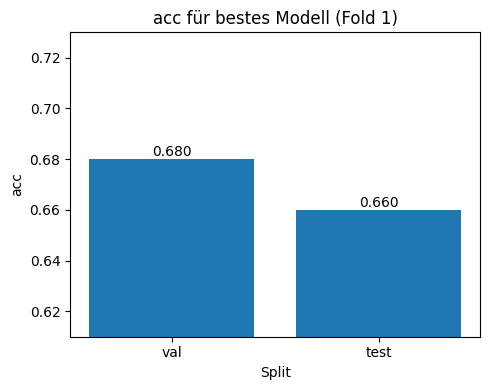

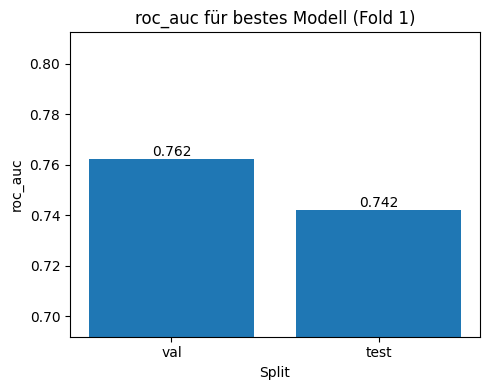

In [ ]:
# === 5) Performance-Zusammenfassung aus CV-Results ===

# Pfad zur CV-Resultate-CSV aus dem Trainings-Notebook
CV_CSV = REPORTS_DIR / "cv_results_tuned_dropout_keras.csv"
assert CV_CSV.exists(), f"CV-Results CSV nicht gefunden: {CV_CSV}"

# CSV laden
df_cv = pd.read_csv(CV_CSV)

# Bestes Modell identifizieren: gleicher Fold + gleicher originaler model_path wie in best_meta
# Im Trainings-Notebook wurde 'original_model_path' in der Meta-JSON abgelegt.
orig_model_path = best_meta.get("original_model_path", None)
if orig_model_path is None:
    # Fallback: falls 'original_model_path' nicht existiert, nutze 'model_path' aus der Meta-Datei
    orig_model_path = best_meta.get("model_path")

# Filter auf Zeilen für das beste Modell in diesem Fold
# CSV: auf Fold + Modelltyp matchen (robust gegen Pfad-Differenzen)
mask_best = (
    (df_cv["split"].isin(["train", "val", "test"])) &
    (df_cv["fold"] == best_fold) &
    (df_cv["model"].astype(str) == best_meta.get("model"))
)

df_best = df_cv[mask_best].copy()
assert not df_best.empty, (
    "Keine passenden Zeilen in CV-CSV gefunden.\n"
    f"fold={best_fold}, model={best_meta.get('model')}"
)

# Relevante Splits in sinnvoller Reihenfolge
splits = ["train", "val", "test"]
metric_cols = ["acc", "f1", "roc_auc", "pr_auc", "ece"]

summary_rows = []
for split in splits:
    sub = df_best[df_best["split"] == split]
    if sub.empty:
        continue
    row = {"split": split}
    for m in metric_cols:
        if m in sub.columns:
            val = sub.iloc[0][m]
            try:
                row[m] = float(val)
            except (TypeError, ValueError):
                row[m] = np.nan
    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows)

print("=== wichtigste Kennzahlen für bestes Modell ===")
print(f"Fold: {best_fold}")
print(f"Modell: {best_meta.get('model', 'unknown')}")
print(f"Originaler Modellpfad (Training): {orig_model_path}")
print(f"Gespeicherter Modellpfad (Evaluation): {best_model_path}\n")

# Tabelle anzeigen
display(df_summary)

# Kompakter Text-Output
for _, r in df_summary.iterrows():
    split = r["split"]
    parts = []
    for m in metric_cols:
        if m in r and pd.notna(r[m]):
            parts.append(f"{m}={r[m]:.4f}")
    print(f"{split:>5}: " + ", ".join(parts))

# Zusätzlicher Überblick: CV-mean/std und finaler Val-Split des retrainierten Modells
print("\n=== CV-Übersicht (aggregierte Hyperparameter-Konfiguration, aus Meta) ===")
print(f"CV mean ROC-AUC: {best_meta.get('cv_mean_roc_auc', float('nan')):.4f} "
      f"+/- {best_meta.get('cv_std_roc_auc', float('nan')):.4f}")
print(f"CV mean F1:      {best_meta.get('cv_mean_f1', float('nan')):.4f} "
      f"+/- {best_meta.get('cv_std_f1', float('nan')):.4f}")

print("\n=== Finaler Validation-Split des retrainierten Modells (aus Meta) ===")
print(f"final acc:     {best_meta.get('acc', float('nan')):.4f}")
print(f"final f1:      {best_meta.get('f1', float('nan')):.4f}")
print(f"final roc_auc: {best_meta.get('roc_auc', float('nan')):.4f}")
print(f"final pr_auc:  {best_meta.get('pr_auc', float('nan')):.4f}")
print(f"final ds_acc:  {best_meta.get('ds_acc', float('nan')):.4f}")
print(f"final ds_f1:   {best_meta.get('ds_f1', float('nan')):.4f}")
print(f"final ds_roc:  {best_meta.get('ds_roc_auc', float('nan')):.4f}")
print(f"final ds_pr:   {best_meta.get('ds_pr_auc', float('nan')):.4f}")

# --- Hilfsfunktion für Balkendiagramme ---
def plot_metric_bar(df_summary: pd.DataFrame,
                    metric: str,
                    save_path: Path) -> None:
    """Einfacher Barplot (Train/Val/Test) für eine gegebene Metrik."""
    if metric not in df_summary.columns:
        print(f"Spalte '{metric}' nicht in df_summary vorhanden, überspringe Plot.")
        return

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.bar(df_summary["split"], df_summary[metric])
    ax.set_xlabel("Split")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} für bestes Modell (Fold {best_fold})")
    # sinnvolle y-Achse für Kennzahlen im [0,1]-Bereich
    try:
        ymin = max(0.0, float(df_summary[metric].min()) - 0.05)
        ymax = min(1.0, float(df_summary[metric].max()) + 0.05)
        if ymin < ymax:
            ax.set_ylim(ymin, ymax)
    except Exception:
        pass

    for i, v in enumerate(df_summary[metric]):
        if pd.notna(v):
            ax.text(i, v, f"{v:.3f}", ha="center", va="bottom")

    fig.tight_layout()
    fig.savefig(save_path, dpi=160, bbox_inches="tight")
    plt.show()

# Balkendiagramme für Accuracy und ROC-AUC erstellen und speichern
plot_metric_bar(df_summary, "acc",     EVAL_DIR / "bar_accuracy_splits.png")
plot_metric_bar(df_summary, "roc_auc", EVAL_DIR / "bar_roc_auc_splits.png")


Lade bestes Modell für Explainability...
Modell geladen.
Last conv layer: conv2d_7

Berechne Vorhersagen für Explainability-Subset...
Explainability-Subset Größe: 200 (100 pos, 100 neg)
7/7 ━━━━━━━━━━━━━━━━━━━━ 639s 82s/step
Explainability-Predictions bereit.
Shapes: (200,) (200,)
Explainability-Indizes (Subset): {'high_neg': 100}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)
/tmp/ipython-input-1340370346.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  hm = cm.get_cmap("jet")(heatmap)[..., :3]


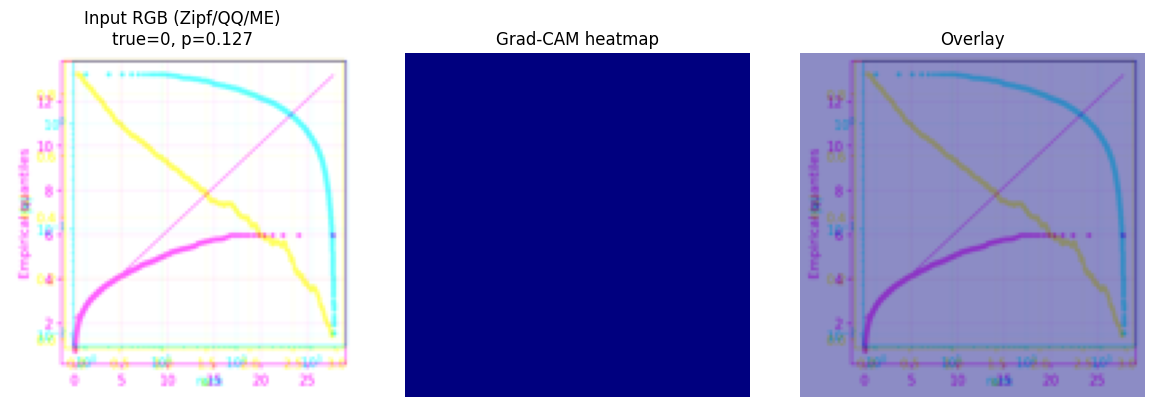

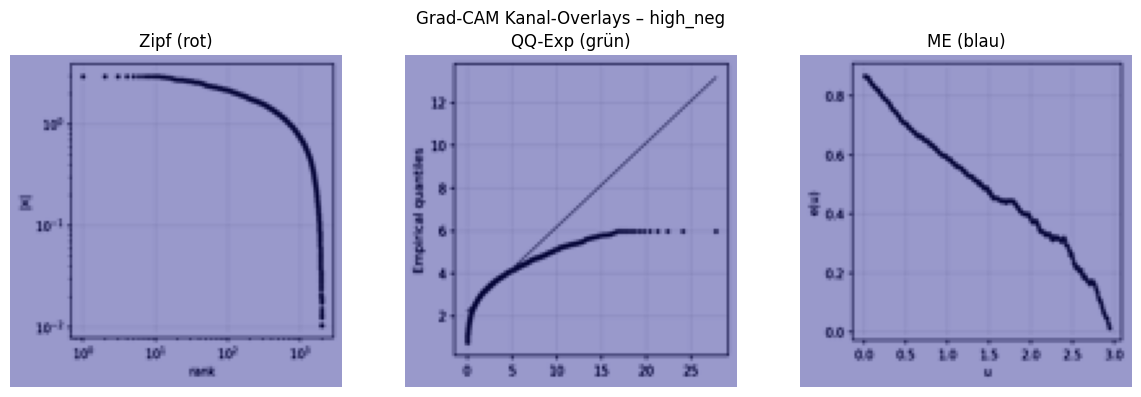

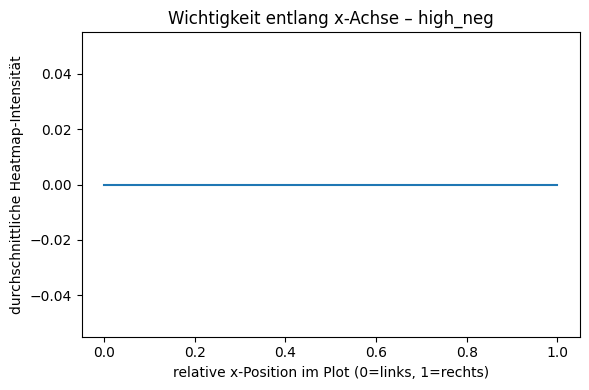

In [ ]:
# === 6.1) Grad-CAM Utilities (aus altem Notebook übernommen/aufgeräumt) ===
def find_last_conv_layer(model: keras.Model) -> str:
    for layer in reversed(model.layers):
        if isinstance(layer, (layers.Conv2D, layers.SeparableConv2D)):
            return layer.name
    raise ValueError("No Conv2D/SeparableConv2D layer found.")

def make_gradcam_heatmap(img_array: np.ndarray,
                         model: keras.Model,
                         last_conv_name: str,
                         pred_index: int | None = None) -> np.ndarray:
    grad_model = keras.Model(
        [model.inputs],
        [model.get_layer(last_conv_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        target = predictions[:, pred_index]
    grads = tape.gradient(target, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)
    heatmap = np.array(
        Image.fromarray((heatmap*255).astype(np.uint8)).resize((IMG_SIZE[1], IMG_SIZE[0]))
    ) / 255.0
    return heatmap

def overlay_heatmap(rgb: np.ndarray,
                    heatmap: np.ndarray,
                    alpha: float = 0.45) -> np.ndarray:
    import matplotlib.cm as cm
    hm = cm.get_cmap("jet")(heatmap)[..., :3]
    out = (1 - alpha) * rgb + alpha * hm
    return np.clip(out, 0, 1)

# ⬇️ HIER: Modell laden, bevor wir den letzten Conv-Layer suchen
print("Lade bestes Modell für Explainability...")
assert best_model_path.exists(), f"Modelldatei nicht gefunden: {best_model_path}"
best_model = keras.models.load_model(best_model_path, compile=False)
print("Modell geladen.")

last_conv_name = find_last_conv_layer(best_model)
print("Last conv layer:", last_conv_name)

# === 6.2) Test-Beispiele auswählen ===
def pick_indices_for_explainability(y: np.ndarray,
                                    p: np.ndarray,
                                    t_low: float,
                                    t_high: float):
    y = np.asarray(y).astype(int)
    p = np.asarray(p).ravel()
    idx_pos = np.where((y == 1) & (p >= 0.8))[0]
    idx_neg = np.where((y == 0) & (p <= 0.2))[0]
    idx_gray = np.where((p >= t_low) & (p <= t_high))[0]

    choices = {}
    if len(idx_pos) > 0:
        choices["high_pos"] = int(idx_pos[0])
    if len(idx_neg) > 0:
        choices["high_neg"] = int(idx_neg[0])
    if len(idx_gray) > 0:
        choices["gray_zone"] = int(idx_gray[0])
    return choices

# --- Mini-Prediction-Funktion NUR für ein Teil-Subset des Test-Splits ---
def predict_rows_for_explainability(all_rows,
                                    max_per_class: int = 100):
    """
    Wählt ein kleineres Subset aus dem Test-Split (max_per_class pro Klasse)
    und berechnet nur dafür Vorhersagen.
    Gibt (subset_rows, y_subset, p_subset) zurück.
    """
    # nach Label aufteilen
    rows_pos = [r for r in all_rows if r["label"] == 1]
    rows_neg = [r for r in all_rows if r["label"] == 0]

    # auf max_per_class begrenzen
    rows_pos = rows_pos[:max_per_class]
    rows_neg = rows_neg[:max_per_class]

    subset_rows = rows_pos + rows_neg
    print(f"Explainability-Subset Größe: {len(subset_rows)} "
          f"({len(rows_pos)} pos, {len(rows_neg)} neg)")

    ys = np.array([r["label"] for r in subset_rows], dtype=np.float32)

    def gen():
        for r in subset_rows:
            x, _ = sample_to_example(r)
            yield x

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=tf.TensorSpec(
            shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
            dtype=tf.float32
        )
    ).batch(BATCH_SIZE_DEFAULT).prefetch(tf.data.AUTOTUNE)

    logits = best_model.predict(ds, verbose=1).squeeze(-1)
    probs = sigmoid(logits / T_best)   # Temperatur-Skalierung

    return subset_rows, ys, probs

print("\nBerechne Vorhersagen für Explainability-Subset...")
rows_expl, y_expl, p_expl = predict_rows_for_explainability(test_rows, max_per_class=100)

print("Explainability-Predictions bereit.")
print("Shapes:", y_expl.shape, p_expl.shape)

# Auswahl der Indizes erfolgt jetzt auf dem kleineren Set
explain_idx = pick_indices_for_explainability(y_expl, p_expl, t_low_best, t_high_best)
print("Explainability-Indizes (Subset):", explain_idx)

# === 6.3) Visualisierung pro Beispiel ===
def explain_sample(row: dict,
                   prob: float,
                   true_label: int,
                   tag: str,
                   save_prefix: Path):
    x_np, _ = sample_to_example(row)  # (H,W,3)
    X = x_np[np.newaxis, ...]
    heatmap = make_gradcam_heatmap(X, best_model, last_conv_name)
    overlay = overlay_heatmap(x_np, heatmap, alpha=0.45)

    # Panel 1: Input / Heatmap / Overlay
    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    axs[0].imshow(x_np)
    axs[0].set_title(f"Input RGB (Zipf/QQ/ME)\ntrue={true_label}, p={prob:.3f}")
    axs[0].axis("off")

    axs[1].imshow(heatmap, cmap="jet")
    axs[1].set_title("Grad-CAM heatmap")
    axs[1].axis("off")

    axs[2].imshow(overlay)
    axs[2].set_title("Overlay")
    axs[2].axis("off")

    fig.tight_layout()
    out1 = save_prefix.parent / f"{save_prefix.name}_rgb_heatmap_overlay.png"
    fig.savefig(out1, dpi=160, bbox_inches="tight")
    plt.show()

    # Panel 2: Kanal-spezifische Overlays
    fig2, axs2 = plt.subplots(1, 3, figsize=(12,4))
    channel_names = ["Zipf (rot)", "QQ-Exp (grün)", "ME (blau)"]
    for c in range(3):
        img_c = x_np[..., c]
        axs2[c].imshow(img_c, cmap="gray")
        axs2[c].imshow(heatmap, cmap="jet", alpha=0.4)
        axs2[c].set_title(f"{channel_names[c]}")
        axs2[c].axis("off")
    fig2.suptitle(f"Grad-CAM Kanal-Overlays – {tag}")
    fig2.tight_layout()
    out2 = save_prefix.parent / f"{save_prefix.name}_channels_overlay.png"
    fig2.savefig(out2, dpi=160, bbox_inches="tight")
    plt.show()

    # Panel 3: Importance entlang der x-Achse
    importance_x = heatmap.mean(axis=0)  # Mittlung über vertikale Richtung
    xs = np.linspace(0, 1, len(importance_x))
    fig3, ax3 = plt.subplots(figsize=(6,4))
    ax3.plot(xs, importance_x)
    ax3.set_xlabel("relative x-Position im Plot (0=links, 1=rechts)")
    ax3.set_ylabel("durchschnittliche Heatmap-Intensität")
    ax3.set_title(f"Wichtigkeit entlang x-Achse – {tag}")
    fig3.tight_layout()
    out3 = save_prefix.parent / f"{save_prefix.name}_importance_x.png"
    fig3.savefig(out3, dpi=160, bbox_inches="tight")
    plt.show()

# Ausgewählte Beispiele erklären (auf Explainability-Subset)
for tag, idx in explain_idx.items():
    row = rows_expl[idx]
    prob = float(p_expl[idx])
    true_label = int(y_expl[idx])
    save_prefix = EVAL_DIR / f"gradcam_test_{tag}"
    explain_sample(row, prob, true_label, tag, save_prefix)


In [ ]:
# === 7.0) Optional: Helper to save real data (e.g. from pyextremes) as CSV for upload ===
import numpy as np
import pandas as pd

def save_series_for_eval(x,
                         filename: str,
                         column_name: str = "value"):
    """
    Helper: speichert eine 1D-Serie x als CSV in CSV_UPLOAD_DIR,
    so dass die bestehende Upload-Pipeline (7.2 / 7.3) sie direkt nutzen kann.

    Parameter
    ---------
    x : array-like
        1D-Zeitreihe oder Extremwerte (z.B. aus pyextremes.EVA).
    filename : str
        Dateiname ohne .csv-Endung (z.B. "pyextremes_danish").
    column_name : str
        Spaltenname in der CSV. "value" ist ideal, weil infer_upload_column
        diese Spalte bevorzugt.
    """
    x = np.asarray(x, dtype="float32").ravel()
    df = pd.DataFrame({column_name: x})
    CSV_UPLOAD_DIR.mkdir(parents=True, exist_ok=True)
    out_path = CSV_UPLOAD_DIR / f"{filename}.csv"
    df.to_csv(out_path, index=False)
    print(f"[INFO] Saved {len(x)} points to: {out_path}")


# === 7.0b) Optional: Reale Daten aus REAL_DIR mit pyextremes vorbereiten ===
try:
    from pyextremes import EVA
except ImportError:
    EVA = None
    print("[WARN] pyextremes ist nicht installiert. "
          "Installiere es z.B. mit `pip install pyextremes` und führe diese Zelle erneut aus.")

# URL zum offiziellen Beispiel-Datensatz aus den pyextremes-Notebooks
PYEXTREMES_EXAMPLE_URL = (
    "https://raw.githubusercontent.com/georgebv/pyextremes-notebooks/master/data/battery_wl.csv"
)

def _infer_real_value_column(df: pd.DataFrame) -> str:
    """
    Wählt eine numerische Spalte aus REAL-CSV:
    - bevorzugt 'value'
    - sonst erste numerische Spalte
    """
    if "value" in df.columns:
        return "value"
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        raise ValueError("Keine numerische Spalte in REAL-CSV gefunden.")
    return num_cols[0]

def _infer_time_index(df: pd.DataFrame) -> pd.Index:
    """
    Versucht eine sinnvolle Zeit-/Indexspalte zu finden:
    - Spalten, die 'date' oder 'time' im Namen haben, werden zu DatetimeIndex geparst.
    - Falls nichts passt: RangeIndex.
    """
    candidates = [c for c in df.columns
                  if ("date" in c.lower()) or ("time" in c.lower())]
    for c in candidates:
        try:
            idx = pd.to_datetime(df[c], errors="coerce")
            if idx.notna().sum() >= len(df) * 0.5:
                return idx
        except Exception:
            continue
    return pd.RangeIndex(start=0, stop=len(df), step=1)

def _ensure_real_csvs_from_pyextremes_example() -> list[Path]:
    """
    Stellt sicher, dass in REAL_DIR mindestens eine CSV liegt.
    Falls REAL_DIR leer ist, wird automatisch der offizielle Beispiel-Datensatz
    'battery_wl.csv' aus den pyextremes-Notebooks heruntergeladen.
    """
    real_paths = sorted(REAL_DIR.glob("*.csv"))
    if real_paths:
        return real_paths

    print(f"[INFO] REAL_DIR ist leer – lade Beispiel-Datensatz von pyextremes:")
    print(f"       {PYEXTREMES_EXAMPLE_URL}")

    try:
        import requests
    except ImportError:
        print("[WARN] 'requests' ist nicht installiert, kann Beispiel-Datensatz nicht laden.")
        return real_paths

    try:
        resp = requests.get(PYEXTREMES_EXAMPLE_URL, timeout=30)
        resp.raise_for_status()
    except Exception as e:
        print(f"[WARN] Download des Beispiel-Datensatzes fehlgeschlagen: {e}")
        return real_paths

    REAL_DIR.mkdir(parents=True, exist_ok=True)
    out_path = REAL_DIR / "battery_wl_pyextremes.csv"
    with open(out_path, "wb") as f:
        f.write(resp.content)

    print(f"[INFO] Beispiel-Datensatz gespeichert nach: {out_path}")
    return sorted(REAL_DIR.glob("*.csv"))

def prepare_pyextremes_from_real_dir(method: str = "BM"):
    """
    Liest alle *.csv aus REAL_DIR, extrahiert Extremwerte via pyextremes.EVA
    und speichert die Extremwerte als neue CSVs in CSV_UPLOAD_DIR,
    so dass 7.2/7.3 sie automatisch evaluiert.

    Wenn REAL_DIR leer ist, wird automatisch der pyextremes-Beispieldatensatz
    'battery_wl.csv' heruntergeladen und verwendet.

    Parameter
    ---------
    method : str
        Methode für EVA.get_extremes (z.B. "BM" oder "POT").
    """
    if EVA is None:
        print("[WARN] EVA-Klasse nicht verfügbar (pyextremes fehlt).")
        return

    # Hier: ggf. Beispiel-Datensatz herunterladen
    real_paths = _ensure_real_csvs_from_pyextremes_example()

    if not real_paths:
        print(f"[INFO] Keine CSV-Dateien in {REAL_DIR} gefunden.")
        return

    print(f"[INFO] Finde {len(real_paths)} REAL-CSV-Datei(en) in {REAL_DIR}")

    for path in real_paths:
        print(f"\n[INFO] Verarbeite REAL-CSV: {path.name}")
        df = pd.read_csv(path)

        try:
            val_col = _infer_real_value_column(df)
        except ValueError as e:
            print(f"[WARN] Überspringe {path.name}: {e}")
            continue

        idx = _infer_time_index(df)
        series = pd.Series(df[val_col].values, index=idx, name=val_col)

        # EVA-Modell aufbauen und Extremwerte extrahieren
        try:
            # In pyextremes heißt der Parameter 'data', nicht 'series'
            eva = EVA(data=series)
            eva.get_extremes(method=method, errors="coerce")
        except Exception as e:
            print(f"[WARN] pyextremes EVA fehlgeschlagen für {path.name}: {e}")
            continue


        if eva.extremes is None or len(eva.extremes) == 0:
            print(f"[WARN] Keine Extremwerte für {path.name} gefunden.")
            continue

        # Extremwerte-Objekt von pyextremes holen
        extremes_obj = eva.extremes

        # Fall 1: pyextremes gibt eine Series zurück (z.B. battery_wl-Beispiel)
        if isinstance(extremes_obj, pd.Series):
            extremes_values = extremes_obj.values

        # Fall 2: pyextremes gibt ein DataFrame zurück
        else:
            extremes_df = extremes_obj

            # Werte-Spalte wählen: bevorzugt 'values', sonst erste numerische Spalte
            if "values" in extremes_df.columns:
                extremes_values = extremes_df["values"].values
            else:
                num_cols_ext = extremes_df.select_dtypes(include=[np.number]).columns
                if len(num_cols_ext) == 0:
                    print(
                        f"[WARN] Keine numerische Spalte in eva.extremes für {path.name}, "
                        "überspringe."
                    )
                    continue
                col_ext = num_cols_ext[0]
                extremes_values = extremes_df[col_ext].values


        if len(extremes_values) == 0:
            print(f"[WARN] Extremwerte-Serie leer für {path.name}, überspringe.")
            continue

        upload_name = f"{path.stem}_extremes_{method.lower()}"
        save_series_for_eval(extremes_values, filename=upload_name, column_name="value")

    print("\n[INFO] Vorbereitung via pyextremes abgeschlossen. "
          "Die erzeugten Extremwerte-CSV-Dateien liegen nun in CSV_UPLOAD_DIR "
          "und werden in 7.2/7.3 automatisch vom besten Modell evaluiert.")

# <<< WICHTIG: automatischer Aufruf HIER, NICHT ganz am Ende des Notebooks >>>
# Dadurch werden die CSVs in CSV_UPLOAD_DIR erzeugt, BEVOR 7.2 / 7.3 laufen.
prepare_pyextremes_from_real_dir(method="BM")


[INFO] Finde 1 REAL-CSV-Datei(en) in /content/drive/MyDrive/Generated Data for Data science project/real

[INFO] Verarbeite REAL-CSV: battery_wl_pyextremes.csv


/usr/local/lib/python3.12/dist-packages/pyextremes/extremes/block_maxima.py:138: NoDataBlockWarning: 4 blocks contained no data
  warnings.warn(


[INFO] Saved 100 points to: /content/drive/MyDrive/Generated Data for Data science project/csv_upload/battery_wl_pyextremes_extremes_bm.csv

[INFO] Vorbereitung via pyextremes abgeschlossen. Die erzeugten Extremwerte-CSV-Dateien liegen nun in CSV_UPLOAD_DIR und werden in 7.2/7.3 automatisch vom besten Modell evaluiert.


In [ ]:
# === 7.1) Plot-Funktionen für Real-Series → Zipf/QQ-Exp/ME (IDENTISCH zur Datengenerierung) ===
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# 1:1 wie im Datengenerierungs-Notebook
DPI     = 150
FIGSIZE = (4.0, 4.0)

plt.rcParams["figure.dpi"]    = DPI
plt.rcParams["savefig.dpi"]   = DPI
plt.rcParams["figure.figsize"]= FIGSIZE


def fig_to_gray_array(fig, size=IMG_SIZE) -> np.ndarray:
    """
    Matplotlib-Figure → Graustufen-Array (0..1), auf IMG_SIZE skaliert.
    WICHTIG: kein bbox_inches="tight" (damit Layout identisch bleibt).
    """
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=DPI)   # <-- KEIN bbox_inches
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("L").resize((size[1], size[0]))
    return (np.asarray(img).astype("float32") / 255.0)


# --- Utilities 1:1 wie in Datengenerierung ---
def _sanitize(x):
    x = np.asarray(x).ravel()
    return x[~np.isnan(x) & ~np.isinf(x)]

def _downsample(x, max_points=50_000, rng=None):
    n = x.shape[0]
    if n <= max_points:
        return x
    if rng is None:
        rng = np.random.default_rng()
    idx = rng.choice(n, size=max_points, replace=False)
    return x[idx]

def _clamp_by_percentile(x, pct=99.5):
    lo = np.nanpercentile(x, 100 - pct)
    hi = np.nanpercentile(x, pct)
    if not np.isfinite(lo): lo = np.nanmin(x)
    if not np.isfinite(hi): hi = np.nanmax(x)
    x = np.clip(x, lo, hi)
    return x, (lo, hi)


# --- Plot-Figures (für Anzeige) ---
def make_zipf_fig(x: np.ndarray, rng=None):
    x = _sanitize(np.abs(x))
    x = _downsample(x, rng=rng)
    x = np.sort(x)[::-1]
    ranks = np.arange(1, x.size + 1)

    fig, ax = plt.subplots()
    ax.loglog(ranks, x, marker=".", linewidth=0)
    ax.set_xlabel("rank")
    ax.set_ylabel("|x| (sorted)")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    return fig

def make_me_fig(x: np.ndarray, n_bins: int = 200, rng=None):
    x = _sanitize(np.abs(x))
    x = _downsample(x, rng=rng)
    x, (lo, hi) = _clamp_by_percentile(x, 99.5)
    xs = np.sort(x)

    us = np.linspace(lo, hi, n_bins)
    e_vals = []
    for u in us:
        exceed = xs[xs > u]
        e_vals.append(np.mean(exceed - u) if exceed.size else np.nan)

    fig, ax = plt.subplots()
    ax.plot(us, e_vals, marker=".", linewidth=1)
    ax.set_xlabel("u")
    ax.set_ylabel("e(u)")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    return fig

def make_qq_exp_fig(x: np.ndarray, rng=None):
    x = _sanitize(np.abs(x))
    x = _downsample(x, rng=rng)
    x = np.sort(x)
    n = x.size

    fig, ax = plt.subplots()
    if n == 0:
        ax.set_title("Empty sample")
    else:
        p = (np.arange(1, n + 1) - 0.5) / n
        q_theory = -np.log1p(-p)
        ax.plot(q_theory, x, marker=".", linewidth=0)
        ax.set_xlabel("Exp(1) quantiles")
        ax.set_ylabel("Sample |x| quantiles")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    return fig


# --- Array-Builder für CNN (nutzt exakt die Fig-Generatoren) ---
def plot_zipf_array(x: np.ndarray, rng=None) -> np.ndarray:
    fig = make_zipf_fig(x, rng=rng)
    return fig_to_gray_array(fig, size=IMG_SIZE)

def plot_me_array(x: np.ndarray, n_pts: int = 200, rng=None) -> np.ndarray:
    # n_pts entspricht hier n_bins aus Training
    fig = make_me_fig(x, n_bins=n_pts, rng=rng)
    return fig_to_gray_array(fig, size=IMG_SIZE)

def plot_qq_norm_array(x: np.ndarray, rng=None) -> np.ndarray:
    # Name bleibt (keine Abhängigkeiten brechen), Inhalt ist QQ vs Exp(1) wie im Training
    fig = make_qq_exp_fig(x, rng=rng)
    return fig_to_gray_array(fig, size=IMG_SIZE)

def build_rgb_from_series(x: np.ndarray, rng=None) -> np.ndarray:
    # WICHTIG: Reihenfolge wie im Datengenerierungs-Notebook (render_plots):
    # zipf -> me -> qq_exp
    # (damit der gleiche RNG-Stream identisch "verbraucht" wird)
    z = plot_zipf_array(x, rng=rng)
    m = plot_me_array(x, rng=rng)
    q = plot_qq_norm_array(x, rng=rng)   # intern QQ-Exp

    # CNN-Channel-Order bleibt wie im Training: [zipf, qq, me]
    return np.stack([z, q, m], axis=-1)


Gefundene Upload-CSV-Dateien: 1


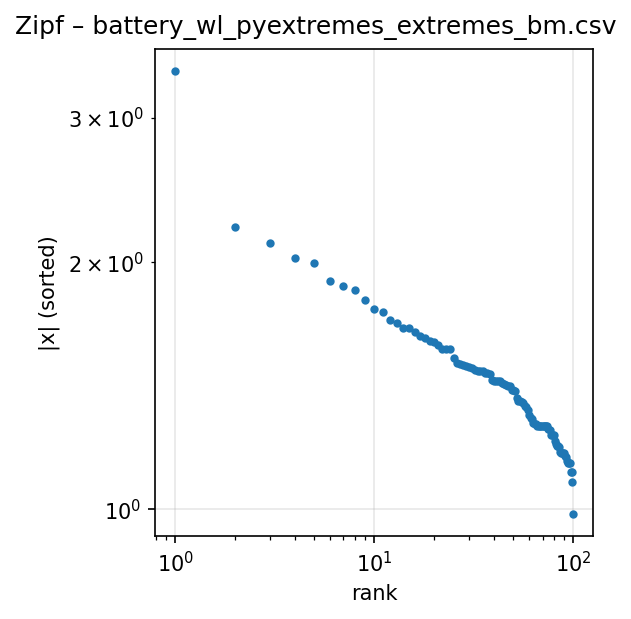

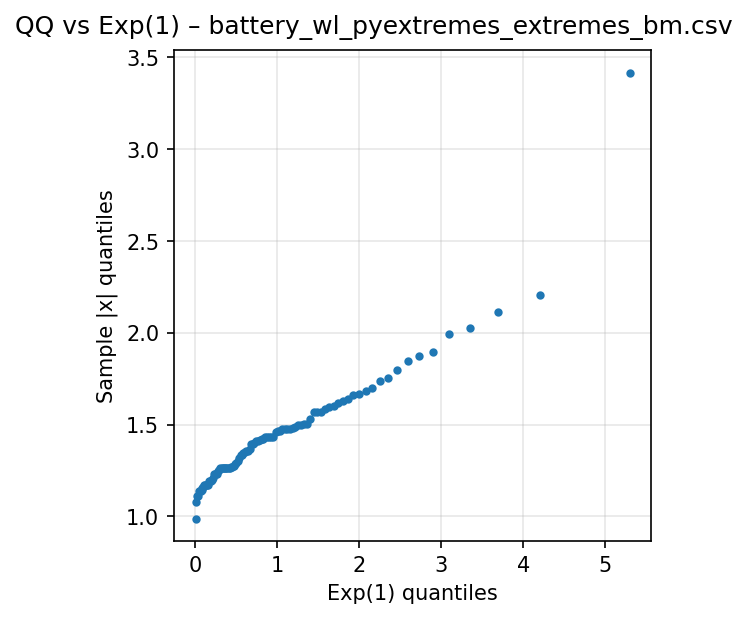

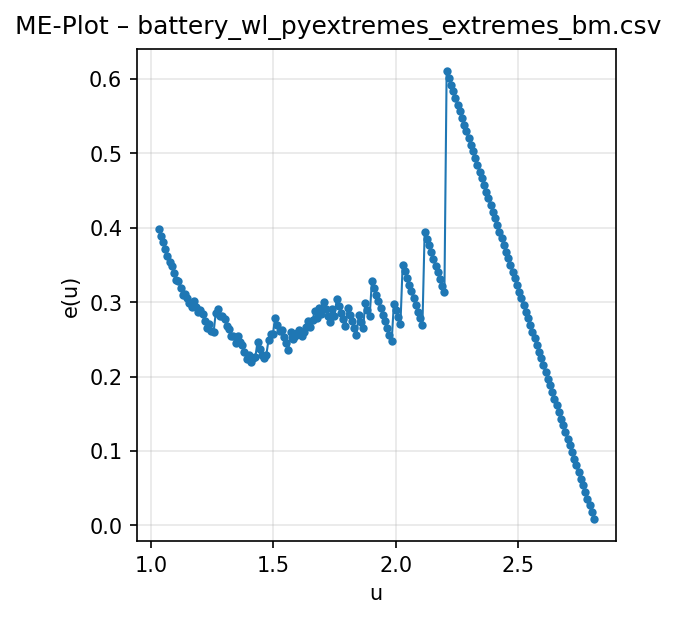

Upload-Batch-Shape: (1, 128, 128, 3)


In [ ]:
# === 7.2) CSVs einlesen & RGB-Batches bauen ===
UPLOAD_COLUMN_DEFAULT = "value"

def infer_upload_column(df: pd.DataFrame,
                        default: str = UPLOAD_COLUMN_DEFAULT) -> str:
    if default in df.columns:
        return default
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        raise ValueError("CSV enthält keine numerische Spalte.")
    return num_cols[0]

upload_paths = sorted([
    p for p in CSV_UPLOAD_DIR.glob("*.csv")
    if not p.name.lower().startswith("predictions_")
])
print(f"Gefundene Upload-CSV-Dateien: {len(upload_paths)}")

rgbs = []
meta_rows = []

for path in upload_paths:
    df = pd.read_csv(path)
    try:
        col = infer_upload_column(df)
    except ValueError as e:
        print(f"[WARN] Überspringe {path.name}: {e}")
        continue
    x_series = df[col].values.astype("float32")
    if len(x_series) == 0:
        print(f"[WARN] Überspringe {path.name}: Spalte {col} ist leer.")
        continue

    # deterministischer RNG pro Datei (stabil über Runs)
    # -> damit Downsampling & Plot-Raster für diese Serie reproduzierbar ist
    seed_series = (SEED + (abs(hash(path.name)) % (2**31 - 1)))  # int im Bereich
    rng_series = np.random.default_rng(seed_series)

    # RGB für CNN bauen (mit exakt dem gleichen RNG-Stream wie bei der Anzeige)
    rgb = build_rgb_from_series(x_series, rng=rng_series)

    # <<<zeige die 3 Plots pro Serie (Model-Input sichtbar machen) >>>
    # WICHTIG: gleiche Reihenfolge wie Datengenerierung: zipf -> me -> qq_exp
    rng_vis = np.random.default_rng(seed_series)

    fig_z = make_zipf_fig(x_series, rng=rng_vis)
    fig_m = make_me_fig(x_series, rng=rng_vis)
    fig_q = make_qq_exp_fig(x_series, rng=rng_vis)


    # Titel nur für Anzeige (nicht fürs CNN-Raster!)
    fig_z.suptitle(f"Zipf – {path.name}", y=1.02)
    fig_q.suptitle(f"QQ vs Exp(1) – {path.name}", y=1.02)
    fig_m.suptitle(f"ME-Plot – {path.name}", y=1.02)

    plt.show(fig_z)
    plt.show(fig_q)
    plt.show(fig_m)


    rgbs.append(rgb)
    meta_rows.append({
        "file_name": path.name,
        "column_used": col,
        "n_points": len(x_series),
    })

if rgbs:
    X_upload = np.stack(rgbs, axis=0)
    print("Upload-Batch-Shape:", X_upload.shape)
else:
    X_upload = None
    print("Keine gültigen Upload-CSV-Dateien gefunden.")

,file_name,column_used,n_points,prob_heavy_tail,pred_0_5,pred_t_opt,in_gray_zone
0,battery_wl_pyextremes_extremes_bm.csv,value,100,0.126516,0,1,False


Predictions gespeichert nach: /content/drive/MyDrive/Generated Data for Data science project/csv_upload/predictions_best_model.csv


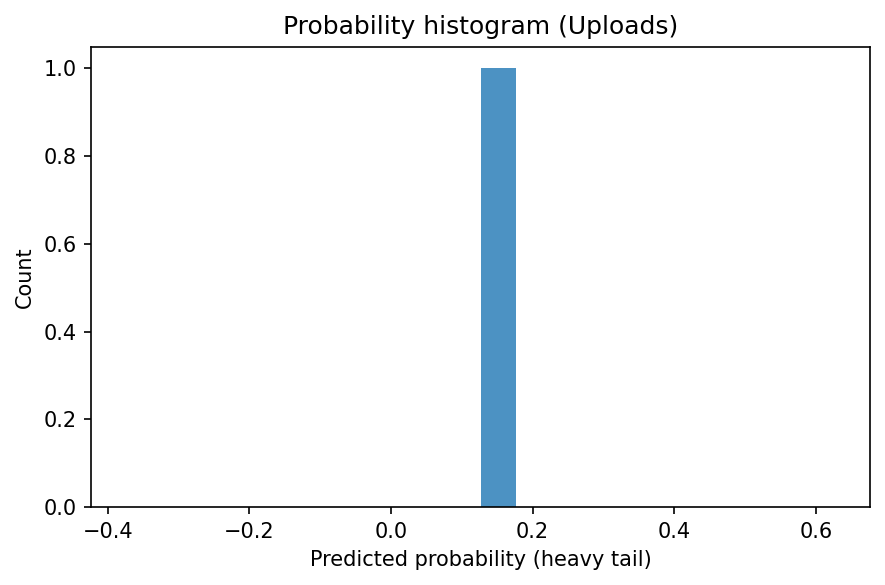

In [ ]:
# === 7.3) Vorhersagen mit bestem Modell ===
if X_upload is not None:
    logits_upload = best_model.predict(X_upload, batch_size=1, verbose=0).squeeze(-1)
    probs_upload  = sigmoid(logits_upload / T_best)

    pred_0_5  = (probs_upload >= 0.5).astype(int)
    pred_topt = (probs_upload >= t_opt_best).astype(int)
    in_gray   = (probs_upload >= t_low_best) & (probs_upload <= t_high_best)

    df_pred = pd.DataFrame(meta_rows)
    df_pred["prob_heavy_tail"] = probs_upload
    df_pred["pred_0_5"]        = pred_0_5
    df_pred["pred_t_opt"]      = pred_topt
    df_pred["in_gray_zone"]    = in_gray

    display(df_pred)

    out_csv = CSV_UPLOAD_DIR / "predictions_best_model.csv"
    df_pred.to_csv(out_csv, index=False)
    print("Predictions gespeichert nach:", out_csv)

    # Histogramm über alle Upload-Probabilities
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(probs_upload, bins=20, alpha=0.8)
    ax.set_xlabel("Predicted probability (heavy tail)")
    ax.set_ylabel("Count")
    ax.set_title("Probability histogram (Uploads)")
    fig.tight_layout()
    fig.savefig(EVAL_DIR / "hist_probs_uploads.png", dpi=160, bbox_inches="tight")
    plt.show()

else:
    print("Keine Upload-Daten für Vorhersagen vorhanden.")